# DC2 Image Analysis, 511keV, Upsampling

updated on 2024-05-30 (the commit 57352ad210f8e1a80cbab5d29730e8aaedf4f782)

This notebook explains image reconstruction using the pixel resolution of the model map finer than that of the response matrix.

Note that this notebook is advanced. It is assumed that you have already performed the two notebooks (511keV-DC2-ScAtt-DataReduction.ipynb, 511keV-DC2-ScAtt-ImageDeconvolution.ipynb).

## Point

In the current implementation, the pixel size of the model map can be differnt from that of the response matrix. The model pixel size is used in the following instances:

- coordsys_conv_matrix
- image_deconvolution

Thus, make sure that NSIDE in these instances must be the same. In this notebook, I present the case with NSIDE = 32 in the model map.

When we convert the model map in the galactic coordinate to the detector coordinate, the pixel size will be downscaled so as the converted model map has the same pixel resolution matching the detector response.
Thus, using finer resolution in the model space does not improve the angular resolution in principle, while the reconstructed image will be smoother.

There are three different NSIDE defined in the analysis:

- NSIDE for the pixel resolution of the model (coordsys_conv_matrix, image_deconvolution)
- NSIDE for the pixel resolution of the response/data/background CDS (full_detector_response, inputs_511keV_DC2.yaml)
- NSIDE for the pixel resolution of the spacecraftattitude binning (exposure_table)

Normally, these three values are set equal, but in principle they can be different.

In [1]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataLoader, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

%matplotlib inline

Welcome to JupyROOT 6.24/06


09:56:53 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=674173;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=110797;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=652472;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=831738;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=511590;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=864859;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=182067;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=48162;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=572840;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=181845;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=645649;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=934633;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=897790;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=985814;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=131045;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=517230;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=108223;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=57585;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

09:56:53 INFO      Starting 3ML!                                                                     ]8;id=828006;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=89183;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=520071;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=899642;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=493786;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=208375;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=758284;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=819931;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=746124;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=45913;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=316174;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=28829;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=35057;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=243269;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=17124;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=513804;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

09:56:54 WARNING   No fermitools installed                                              ]8;id=376228;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=783357;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

09:56:54 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=442030;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=989147;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=994483;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=399988;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=721030;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=179635;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

In [2]:
nside_scatt_binning = 32
nside_model = 32

**In this notebook I change the NSIDE in the exposure table, so the binned data need to be reproduced.**

# 0. Prepare the data

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori

From docs/tutorials/image_deconvolution/511keV/ScAttBinning
- inputs_511keV_DC2.yaml
- imagedeconvolution_parfile_scatt_511keV.yml

## Load the response and orientation files

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "path/to/data/"

In [4]:
%%time

ori_filepath = path_data + "20280301_3_month.ori"
ori = SpacecraftFile.parse_from_file(ori_filepath)

CPU times: user 16 s, sys: 1.39 s, total: 17.4 s
Wall time: 16.9 s


In [5]:
full_detector_response_filename = path_data + "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
full_detector_response = FullDetectorResponse.open(full_detector_response_filename)

nside_local = full_detector_response.nside
npix_local = hp.nside2npix(nside_local)

nside_local

16

In [6]:
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 3072
    NSIDE: 16
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 60
    EDGES: [0.0 deg, 3.0 deg, 6.0 deg, 9.0 deg, 12.0 deg, 15.0 deg, 18.0 deg, 21.0 deg, 24.0 deg, 27.0 deg, 30.0 deg, 33.0 deg, 36.0 deg, 39.0 deg, 42.0 deg, 45.0 deg, 48.0 deg, 51.0 deg, 54.0 deg, 57.0 deg, 60.0 deg, 63.0 deg, 66.0 deg, 69.0 deg, 72.0 deg, 75.0 deg, 78.0 deg, 81.0 deg, 84.0 deg, 87.0 deg, 90.0 deg, 93.0

# 1. analyze the orientation file

This section is the same as in 511keV-DC2-ScAtt-DataReduction.ipynb, but the nisde is changed to 32.

In [8]:
%%time

exposure_table = SpacecraftAttitudeExposureTable.from_orientation(ori, nside = nside_scatt_binning, start = None, stop = None)
exposure_table

angular resolution:  1.8322594196359498 deg.



WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"



duration:  92.36059027777777 d



WARNING ErfaWarning: ERFA function "utctai" yielded 7979955 of "dubious year (Note 3)"



  0%|          | 0/7979955 [00:00<?, ?it/s]

CPU times: user 1min 12s, sys: 1.89 s, total: 1min 14s
Wall time: 1min 14s


,scatt_binning_index,healpix_index,zpointing,xpointing,zpointing_averaged,xpointing_averaged,delta_time,exposure,num_pointings,bkg_group
0,0,"(8272, 427)","[[44.62664815323754, -21.585226694584346], [44...","[[44.62664815323755, 68.41477330541565], [44.6...","[44.49705286596814, -21.370653963754705]","[44.49899938347305, 68.62948123249228]","[0.9999999999969589, 1.0000000000065512, 0.999...",22051.0,22051,0
1,1,"(8399, 427)","[[44.78167623289732, -21.840823005240516], [44...","[[44.781676232897325, 68.15917699475948], [44....","[44.84546317102121, -21.94574666279381]","[44.845668028631366, 68.05426833879696]","[0.9999999999969589, 0.9999999999969589, 0.999...",7207.0,7207,0
2,2,"(8528, 427)","[[44.937249783176014, -22.096275698920152], [4...","[[44.93724978317603, 67.90372430107985], [44.9...","[45.280789592422735, -22.65671255168847]","[45.28405398202019, 67.34354151639131]","[0.9999999999969589, 1.0000000000065512, 0.999...",29025.0,29025,0
3,3,"(8528, 488)","[[45.66020516346508, -23.269427365755966], [45...","[[45.6602051634651, 66.73057263424403], [45.69...","[45.792486557202956, -23.48162697469867]","[45.79313907872797, 66.51842748236865]","[1.0000000000065512, 0.9999999999969589, 0.999...",13091.0,13091,0
4,4,"(8656, 488)","[[45.978454945885545, -23.778456203550505], [4...","[[45.978454945885545, 66.22154379644951], [46....","[46.11600105920392, -23.997057178710705]","[46.11666483156788, 66.00300061062126]","[0.9999999999969589, 0.9999999999969589, 1.000...",13268.0,13268,0
...,...,...,...,...,...,...,...,...,...,...
562,562,"(3526, 515)","[[19.469949806943756, 24.43289490159796], [19....","[[199.46994980694376, 65.56710509840204], [199...","[19.471417500535573, 24.430350678106848]","[199.47141729115225, 65.56964934798671]","[1.000000000001755, 0.9999999999969589, 0.9999...",257.0,257,0
563,563,"(745, 3302)","[[289.1161733315789, 62.182064711183735], [289...","[[109.11617333157892, 27.817935288816265], [10...","[289.1158698854739, 62.181869345669945]","[109.11587008833249, 27.818130910219594]","[0.9999999999969589, 1.0000000000065512, 0.999...",216.0,216,0
564,564,"(11555, 3438)","[[129.37391657068838, -62.722167168565605], [1...","[[129.37391657068838, 27.277832831434402], [12...","[129.3748932372682, -62.7229126247577]","[129.3748932228599, 27.277087393995096]","[0.9999999999969589, 0.9999999999969589, 0.999...",38.0,38,0
565,565,"(749, 3438)","[[309.37452108662, 62.72183635479668], [309.37...","[[129.37452108662, 27.27816364520332], [129.37...","[309.3747190421793, 62.723149712157756]","[129.37471903379148, 27.27685031183828]","[0.9999999999969589, 1.0000000000065512, 1.000...",57.0,57,0


You can save SpacecraftAttitudeExposureTable as a fits file.

In [9]:
exposure_table.save_as_fits(f"exposure_table_nside{nside_scatt_binning}.fits", overwrite = True)

You can also read the fits file.

In [10]:
exposure_table_from_fits = SpacecraftAttitudeExposureTable.from_fits(f"exposure_table_nside{nside_scatt_binning}.fits")
exposure_table == exposure_table_from_fits

True

# 2. Calculate the coordinate conversion matrix


CoordsysConversionMatrix.spacecraft_attitude_binning_ccm can produce the coordinate conversion matrix for the spacecraft attitude binning.

In this calculation, we calculate the exposure time map in the detector coordinate for each model pixel and each scatt_binning_index. We refer to it as the dwell time map.

If use_averaged_pointing is True, first the averaged Z- and X-pointings are calculated (the average of zpointing or xpointing in the exposure table) for each scatt_binning_index, and then the dwell time map is calculated assuming the averaged pointings for each model pixel and each scatt_binning_index.

If use_averaged_pointing is False, the dwell time map is calculated for each attitude in zpointing and xpointing (basically every 1 second), and then the calculated dwell time maps are summed up for each model pixel and each scatt_binning_index. 

In the former case, the computation is fast but may lose the angular resolution. In the latter case, the conversion matrix is more accurate, but it takes a very long time to calculate it.

**With NSIDE = 32, this process may take a few hours. I also prepared a python script to create the conversion matrix. If the notebook does not work, you can use mk_ccm_upsampling.py**

In [ ]:
%%time

coordsys_conv_matrix = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table, 
                                                                                nside_model = nside_model, use_averaged_pointing = True,
                                                                                earth_horizon_angle = 113.0 * u.deg)

You can save CoordsysConversionMatrix as a hdf5 file.

In [ ]:
coordsys_conv_matrix.write(f"ccm_nside{nside_model}.hdf5", overwrite = True)

You can also read the saved file.

In [8]:
coordsys_conv_matrix = CoordsysConversionMatrix.open(f"ccm_nside{nside_model}.hdf5")

**Check the matrix shape**

In [9]:
coordsys_conv_matrix.contents

Format,coo
Data Type,float64
Shape,"(567, 12288, 3072)"
nnz,19450362
Density,0.0009087453793946748
Read-only,True
Size,593.6M
Storage ratio,0.0


# 3. produce the binned data

In [10]:
def get_binned_data_scatt(unbinned_event, exposure_table, psichi_binning = 'local', sparse = False):
    exposure_dict = {row['healpix_index']: row['scatt_binning_index'] for _, row in exposure_table.iterrows()}
        
    # from BinnedData.py
 
    # Get energy bins:
    energy_bin_edges = np.array(unbinned_event.energy_bins)
    
    # Get phi bins:
    number_phi_bins = int(180./unbinned_event.phi_pix_size)
    phi_bin_edges = np.linspace(0,180,number_phi_bins+1)
    
    # Define psichi axis and data for binning:
    if psichi_binning == 'galactic':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = 'galactic', label='PsiChi')
        coords = SkyCoord(l=unbinned_event.cosi_dataset['Chi galactic']*u.deg, b=unbinned_event.cosi_dataset['Psi galactic']*u.deg, frame = 'galactic')
    if psichi_binning == 'local':
        psichi_axis = HealpixAxis(nside = unbinned_event.nside, scheme = unbinned_event.scheme, coordsys = SpacecraftFrame(), label='PsiChi')
        coords = SkyCoord(lon=unbinned_event.cosi_dataset['Chi local']*u.rad, lat=((np.pi/2.0) - unbinned_event.cosi_dataset['Psi local'])*u.rad, frame = SpacecraftFrame())

    # Define scatt axis and data for binning
    n_scatt_bins = len(exposure_table)
    scatt_axis = Axis(np.arange(n_scatt_bins + 1), label='ScAtt')
    
    is_nest = True if exposure_table.scheme == 'nested' else False
    
    nside_scatt = exposure_table.nside
    
    zindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Zpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)
    xindex = hp.ang2pix(nside_scatt, unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[0] * 180 / np.pi, 
                        unbinned_event.cosi_dataset['Xpointings (glon,glat)'].T[1] * 180 / np.pi, nest=is_nest, lonlat=True)    
    scatt_data = np.array( [ exposure_dict[(z, x)] + 0.5 if (z,x) in exposure_dict.keys() else -1 for z, x in zip(zindex, xindex)] ) # should this "0.5" be needed?
    
    # Initialize histogram:
    binned_data = Histogram([scatt_axis,
                              Axis(energy_bin_edges*u.keV, label='Em'),
                              Axis(phi_bin_edges*u.deg, label='Phi'),
                              psichi_axis],
                              sparse=sparse)

    # Fill histogram:
    binned_data.fill(scatt_data, unbinned_event.cosi_dataset['Energies']*u.keV, np.rad2deg(unbinned_event.cosi_dataset['Phi'])*u.deg, coords)    
    
    return binned_data

In [12]:
%%time

signal_filepath = path_data + "511_thin_disk_3months_unbinned_data.fits.gz"

unbinned_signal = UnBinnedData(input_yaml = "inputs_511keV_DC2.yaml")

unbinned_signal.cosi_dataset = unbinned_signal.get_dict_from_fits(signal_filepath)

binned_signal = get_binned_data_scatt(unbinned_signal, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 5.9 s, sys: 417 ms, total: 6.32 s
Wall time: 6.33 s


In [13]:
%%time

bkg_filepath = path_data + "albedo_photons_3months_unbinned_data.fits.gz"

unbinned_bkg = UnBinnedData(input_yaml = "inputs_511keV_DC2.yaml")

unbinned_bkg.cosi_dataset = unbinned_bkg.get_dict_from_fits(bkg_filepath)

binned_bkg = get_binned_data_scatt(unbinned_bkg, exposure_table, psichi_binning = 'local', sparse = False)

CPU times: user 1min 34s, sys: 4.66 s, total: 1min 38s
Wall time: 1min 38s


In [14]:
binned_event = binned_signal + binned_bkg

# 4. Imaging deconvolution

## 4-1. Prepare DataLoader containing all neccesary datasets

In [15]:
dataloader = DataLoader.load(binned_event, 
                             binned_bkg, 
                             full_detector_response,
                             coordsys_conv_matrix,
                             is_miniDC2_format = False)

In [16]:
dataloader._modify_axes()


WARNING FutureWarning: Note that _modify_axes() in DataLoader was implemented for a temporary use. It will be removed in the future.


WARNING UserWarning: Make sure to perform _modify_axes() only once after the data are loaded.



... checking the axis ScAtt of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.


## 4-2. Load the response file

In [17]:
%%time

dataloader.load_full_detector_response_on_memory()
dataloader.calc_image_response_projected() # mandatory

... (DataLoader) calculating a projected image response ...
CPU times: user 16.5 s, sys: 2.61 s, total: 19.1 s
Wall time: 19.5 s


## 4-3. Initialize the instance of the image deconvolution class

In [18]:
parameter_filepath = "imagedeconvolution_parfile_scatt_511keV.yml"

In [19]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x2cc0f3b80>
parameter file for image deconvolution was set ->  imagedeconvolution_parfile_scatt_511keV.yml


**Do not forget to make sure that NSIDE of the model map is modified to 32**

In [20]:
image_deconvolution.override_parameter(f"model_property:nside = {nside_model}")

In [21]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 20")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 10")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 2.5")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 509.0
- 513.0
nside: 32
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/12288 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 20
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 2.5

#### Done ####



## 4-5. Start the image deconvolution

**With MacBook Pro with M1 Max and 64 GB memory, it takes about 9 minutes for 20 iterations.**

In [22]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/20 [00:00<?, ?it/s]

  Iteration 1/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 2.0959303962166596
    loglikelihood: -1744187.311369216
    background_normalization: 1.0024923543604456
  Iteration 2/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1710826.5401983387
    background_normalization: 0.9979603486227642
  Iteration 3/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1701023.630762956
    background_normalization: 0.9998166641625715
  Iteration 4/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1694813.4639718374
    background_normalization: 0.9999667575745507
  Iteration 5/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1690723.3981969894
    background_normalization: 0.9999641131060623
  Iteration 6/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1687938.9572818861
    background_normalization: 0.9999534539272469
  Iteration 7/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1685972.5059448606
    background_normalization: 0.9999458697143792
  Iteration 8/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1684533.2643010765
    background_normalization: 0.999940852826931
  Iteration 9/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1683445.7031161278
    background_normalization: 0.9999374467434516
  Iteration 10/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1682601.2639740645
    background_normalization: 0.9999350336564081
  Iteration 11/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1681930.637260139
    background_normalization: 0.9999332472108552
  Iteration 12/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1681387.9948765219
    background_normalization: 0.99993187160966
  Iteration 13/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1680941.9738068725
    background_normalization: 0.9999307786535945
  Iteration 14/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1680570.42991131
    background_normalization: 0.999929890772651
  Iteration 15/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1680257.303258601
    background_normalization: 0.9999291595395479
  Iteration 16/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1679990.6827223343
    background_normalization: 0.9999285532375896
  Iteration 17/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1679761.5681644226
    background_normalization: 0.999928049773709
  Iteration 18/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1679563.0514251883
    background_normalization: 0.9999276327156044
  Iteration 19/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1679389.7576947026
    background_normalization: 0.9999272890970821
  Iteration 20/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing



WARNING RuntimeWarning: divide by zero encountered in divide



... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> stop
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: -1679237.4545414133
    background_normalization: 0.9999270082203996
#### Done ####

CPU times: user 29min 56s, sys: 3min 33s, total: 33min 30s
Wall time: 6min 44s


In [23]:
import pprint

pprint.pprint(all_results)

[{'alpha': <Quantity 2.0959304>,
  'background_normalization': 1.0024923543604456,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2b5dd6c50>,
  'iteration': 1,
  'loglikelihood': -1744187.311369216,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2b5dd4f10>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2b5dd68c0>},
 {'alpha': 1.0,
  'background_normalization': 0.9979603486227642,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2b5dd7250>,
  'iteration': 2,
  'loglikelihood': -1710826.5401983387,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2b5dd7040>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2b5dd5180>},
 {'alpha': 1.0,
  'background_normalization': 0.9998166641625715,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x2b5dd4760>,
  'iteration': 3,
  'loglikelihood': -1701023.6307629

# 5. Analyze the results
Examples to see/analyze the results are shown below.

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

Text(0, 0.5, 'loglikelihood')

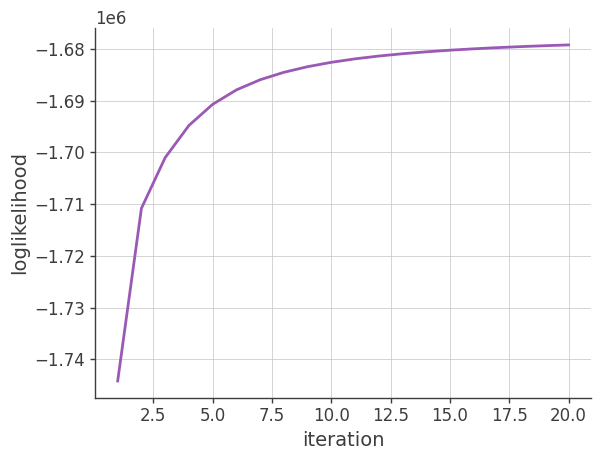

In [24]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

Text(0, 0.5, 'alpha')

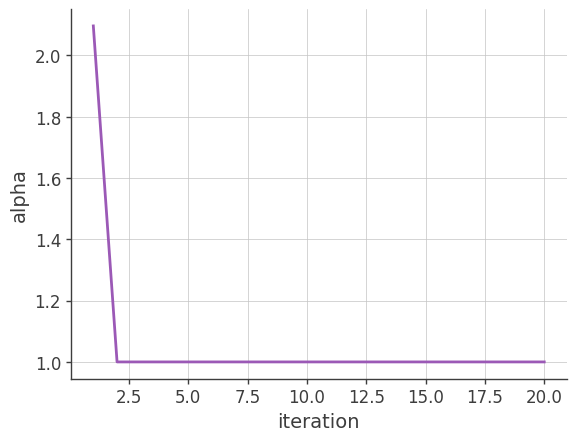

In [25]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the background model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

Text(0, 0.5, 'background_normalization')

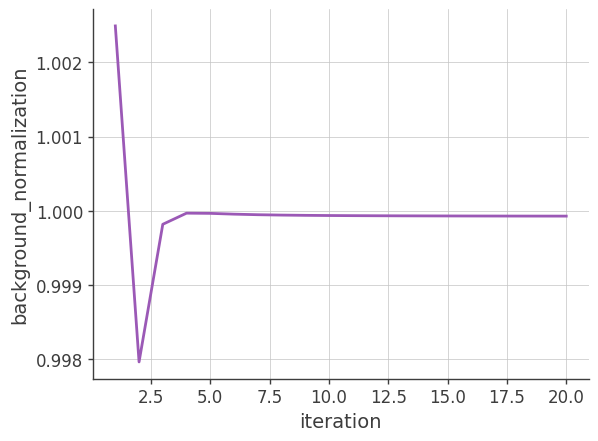

In [26]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")

## The reconstructed images

In [27]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

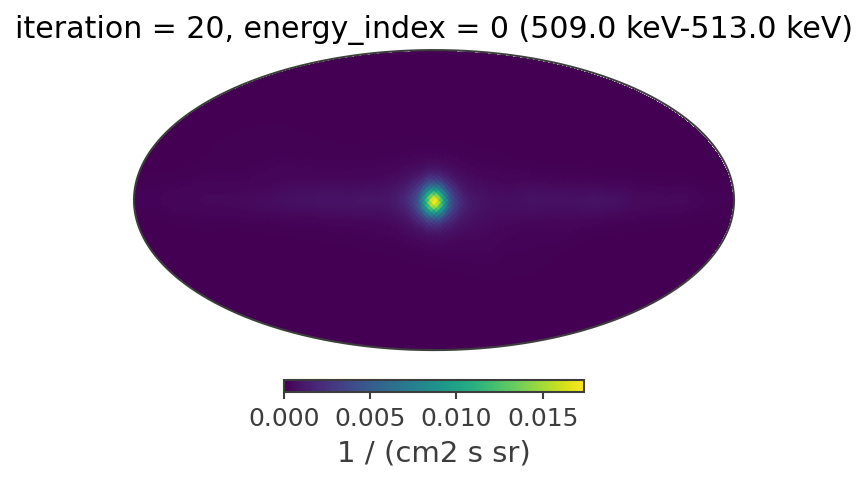

In [28]:
iteration = 19

plot_reconstructed_image(all_results[iteration])

An example to plot the image in the log scale

total flux : 0.002645933686653662 1 / (cm2 s)


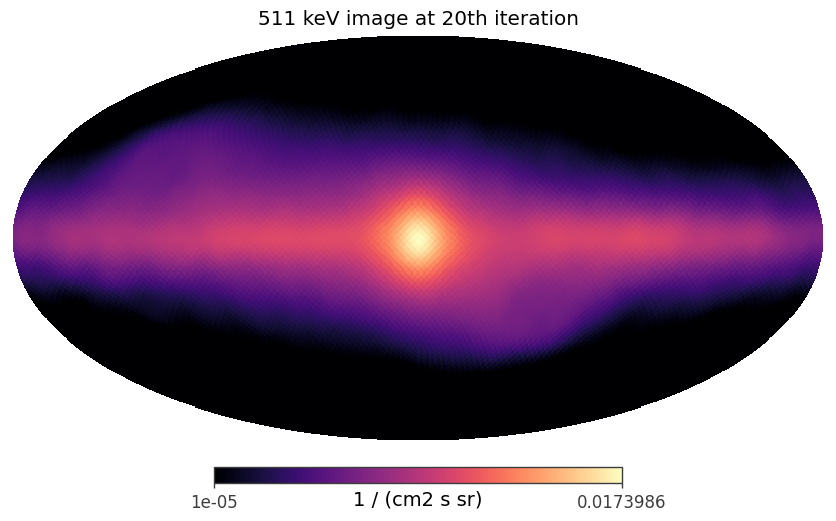

In [30]:
iteration_idx = 19

result = all_results[iteration_idx]

iteration = result['iteration']
image = result['model_map']

print("total flux :", np.sum(image[:,0]) * image.axes['lb'].pixarea())

data = image[:,0]
data[data <= 0 * data.unit] = 1e-12 * data.unit

hp.mollview(data, min = 1e-5, norm ='log', unit = str(data.unit), title = f'511 keV image at {iteration}th iteration', cmap = 'magma')

plt.show()